In [2]:
import pandas as pd
import tkinter as tk
from tkinter import filedialog
from IPython.display import display
import numpy as np
from sklearn.linear_model import LinearRegression
import os

# Paso 0: Preguntar al usuario la moneda de valoración

moneda_valoracion = input("¿En qué moneda deseas valorar los instrumentos? (Ej: CLP, USD): ").strip().upper()
if moneda_valoracion == "":  
    raise ValueError("Debes ingresar una moneda de valoración válida.") 

1. Se usa input(..) para que el usuario pueda escribir "CLP" o "USD" y .strip().upper() elimina espacios al inicio o al final y convierte a mayúsculas.

2. Si el usuario no pone ninguna moneda de valoración el código retornará un error.

--> A partir de aquí toda la valoración se expersará en esa moneda.

In [ ]:
# Paso 1: Seleccionar archivo de forwards

root = tk.Tk()
root.withdraw()
archivo_forwards = filedialog.askopenfilename(
    title="Selecciona el archivo con los forwards", 
    filetypes=[("Excel files", "*.xlsx *.xls")]
)
if not archivo_forwards:
    raise ValueError("No se seleccionó ningún archivo de forwards.")

1. tk.TK() crea una ventana de Tkinter (Necesario para crear la ventana emergente), pero como esto también muestra una ventana principal de Tkinter, se usa root.withdraw() para ocultarla.

2. filedialog.askopenfilename(...) abre un diálogo donde el usuario navega el sistema de archivos y selecciona el Excel de forwards.
        -title: texto que aparece en la barra del diálogo.
        -filetypes: filtro para mostrar solo archivos .xlsx o .xls.

3. Si el usuario cierra el diálogo o presiona cancelar, archivo_forwards queda vacío y arroja un error.

--> Se busca asegurar que se cargue un archivo de forwards.

In [ ]:
# Paso 2: Leer y validar archivo de forwards

columnas_esperadas = [
    'ID', 'Contraparte', 'Inicio', 'Fin', 'Nocional', 'Moneda',
    'Strike', 'Sentido', 'Curva_Activa', 'Curva_Pasiva', 'CDS_Propio', 'CDS_Contraparte', 'Recovery'
]

forwards_df = pd.read_excel(archivo_forwards)
faltantes = set(columnas_esperadas) - set(forwards_df.columns)
if faltantes:
    raise ValueError(f"Faltan columnas en el archivo de forwards: {faltantes}")  # ❸

# Validar que ciertas columnas sean numéricas
for col in ['Nocional', 'Strike', 'CDS_Propio', 'CDS_Contraparte', 'Recovery']:
    if not pd.api.types.is_numeric_dtype(forwards_df[col]):
        raise ValueError(f"La columna '{col}' debe ser numérica.")

# Validar valores de 'Sentido' (solo BUY o SELL)
sentidos_unicos = set(forwards_df['Sentido'].dropna().str.upper().unique())
if not sentidos_unicos.issubset({'BUY', 'SELL'}):
    raise ValueError("La columna 'Sentido' solo puede contener 'BUY' o 'SELL'.")

# Convertir fechas
forwards_df['Inicio'] = pd.to_datetime(forwards_df['Inicio'], errors='raise')
forwards_df['Fin'] = pd.to_datetime(forwards_df['Fin'], errors='raise')

print(f"\n✅ Moneda de valoración: {moneda_valoracion}")
print("✅ Archivo de forwards cargado correctamente:")
display(forwards_df.head())

1. Se definen las columnas esperadas que debería tener el archivo de forwards para que el modelo funcione, es importante que el archivo de inputs de forwards debe tener esas columnas con los nombres tal cual están escrito en el código.

2. Con pd.read_excel(archivo_forwards) carga toda la hoja por defecto (la primera) en el DataFrame forwards_df. Luego se calculan las columnas faltantes si es que aplica, si llegan a faltar columnas el código levantará un error con los nombres de las columnas faltantes.

3. Con for col in ['Nocional', 'Strike', 'CDS_Propio', 'CDS_Contraparte', 'Recovery'], recorremos todas estas columnas y pd.api.types.is_numeric_dtype(...) verifica que cada columna sea de un tipo numérico (int, float). Si alguna no es numérica, el código arrojará un error con el nombre de la columna que no es numérica.

4. Con Sentidos_unicos tomamos la columna forwards_df['Sentido'], quitamos NaN con .dropna(), convertimos todo a mayúsculas .str.upper() y extraemos valores únicos .unique(). Luego, se compara si dicho conjunto está dentro de "Buy" o "Sell", si aparece otro valor dentro del conjunto, el chequeo falla y lanzamos error para forzar que sólo exista una de esas dos opciones.

5. Por último con pd.to_datetime(..., errors='raise') convertimos las columnas 'Inicio' y 'Fin' a tipo datetime64[ns]. Si algún valor no puede pconvertirse a ese tipo de fecha, el código arroja un error. Esto sirve para posteriormente restar fechas fácilmente y calcular días hasta el vencimiento.

--> Este bloque de código busca comprobar que el archivo de inputs contractuales de los forwards tenga toda la información necesaria para el modelo y hace transformaciones necesarias para los datos de este.

In [ ]:
# Paso 3: Identificar monedas únicas y relacionadas

monedas_unicas = forwards_df['Moneda'].unique().tolist()
# Asegurarnos de que la moneda de valoración esté en la lista
if moneda_valoracion not in monedas_unicas:
    raise ValueError(f"La moneda de valoración '{moneda_valoracion}' no aparece en la columna 'Moneda' del archivo.")

monedas_relacionadas = [m for m in monedas_unicas if m != moneda_valoracion]  # lista en lugar de set
# Genéricos de nombres de hojas FX (las validaremos luego)
relaciones_tc = [f"TC_{m}{moneda_valoracion}W" for m in monedas_relacionadas]

1. forwards_df['Moneda'].unique() extrae el arreglo de monedas que aparecen en la columna “Moneda” (por ejemplo, ['USD','CLP']).

2. Se Verifica que la moneda_valoracion efectivamente exista en esa lista. Si no, no podemos continuar porque no hay un forward en la misma moneda de valoración.

3. monedas_relacionadas es la lista de todas las monedas distintas de la moneda_valoracion. Si “Moneda” en los forwards es ['USD','CLP','EUR'] y elegiste “CLP”, entonces monedas_relacionadas = ['USD','EUR'].

4. relaciones_tc arma el nombre de las hojas Excel donde se espera encontrar las series de tipo de cambio. Por ejemplo, si moneda_valoracion='CLP' y m='USD', la hoja esperada es "TC_USDCLPW". Más adelante el código validará si esa hoja existe.

--> El objetivo de este bloque de código es poder identificar que monedas se necesitan simular en FX y preparar nombres de hojas para leer los históricos.

In [ ]:
# Paso 4: Seleccionar archivo de insumos varios

archivo_insumos = filedialog.askopenfilename(
    title="Selecciona el archivo con curvas, tipos de cambio y tasas",
    filetypes=[("Excel files", "*.xlsx *.xls")]
)
if not archivo_insumos:
    raise ValueError("No se seleccionó ningún archivo de insumos.")  # ❽

xls_insumos = pd.ExcelFile(archivo_insumos)

# Diccionarios para guardar inputs

curvas_descuento = {}   # Guardará DataFrames con 'Days' y 'Zero Rate'
datos_fx = {}           # Guardará Series de precios FX indexadas por fecha
tasas_historicas = {}   # Guardará Series de tasas históricas (en decimales)

1. Igual que en el paso 1, se abre un diálogo para que el usuario pueda seleccionar el Excel que debe contener lo siguiente:

   -Una hoja por moneda para cada curva de descuento a la fecha de valoración (Tiene que tener nombre que siga el siguiente patrón "Desc_Moneda"). Por ejemplo si tienes forwards con monedas distintas "USD" y "CLP", deberías tener dos hojas una con la curva de descuento para la moneda USD al 31.12.2024 y con nombre "Desc_USD" y otra con lo mismo pero para la moneda CLP y con nombre "Desc_CLP". Por último esta hoja debe tener dos columnas una que se llame "Days" con los días y otra "Zero Rate" con la tasa.

   -Una hoja con la serie histórica de tasas de las monedas únicas, con nombre libre ya que el código te preguntará el nombre de las hojas, es importante que la serie de tasas tenga dos columnas, una con la fecha y la otra con la tasa en formato decimal, es decir, si la tasa es del 3,5% que aparezca como 3,5.

   -Series de tipo de cambio (hojas con nombre “TC_<moneda><moneda_valoracion>W” o su inversa). Es decir, puede llamarse "TC_USDCLPW" o "TC_CLPUSDW", el código entenderá que son lo mismo. Es importante que que tenga dos columnas "Date" con la fecha y "Price" con el TC.

2. Si el usuario no elige nada, el código lanza un error.

3. Por último se crea un diccionario para guardar todos los datos leídos.

--> El objetivo es consolidar en un solo archivo todos los inputs necesarios para el modelo.

In [ ]:
# Paso 5: Leer curvas y tasas por moneda

for moneda in monedas_unicas:
    print(f"\n--- Procesando insumos para moneda: {moneda} ---")

    # 5.1: Cargar curva de tasas actual (hoja "Desc_<MONEDA>")
    hoja_curva = f"Desc_{moneda}"
    if hoja_curva not in xls_insumos.sheet_names:
        raise ValueError(f"No se encontró la hoja '{hoja_curva}' en el archivo de insumos.")  # ⓬

    curva_df = pd.read_excel(xls_insumos, sheet_name=hoja_curva)
    if not {'Days', 'Zero Rate'}.issubset(curva_df.columns):
        raise ValueError(f"La hoja '{hoja_curva}' debe tener columnas: 'Days' y 'Zero Rate'")  # ⓭

    # Forzar tipos correctos
    curva_df = curva_df[['Days', 'Zero Rate']].copy()
    curva_df['Days'] = curva_df['Days'].astype(int)
    curva_df['Zero Rate'] = curva_df['Zero Rate'].astype(float)

    curvas_descuento[moneda] = curva_df

    # 5.2: Cargar tasas históricas (el usuario elige la hoja)
    print(f"Hojas disponibles: {xls_insumos.sheet_names}")
    hoja_tasa = input(f"Ingresa el nombre de la hoja con tasas históricas para {moneda}: ").strip()
    if hoja_tasa not in xls_insumos.sheet_names:
        raise ValueError(f"No se encontró la hoja '{hoja_tasa}' en el archivo de insumos.")  # ⓯

    df_tasa = pd.read_excel(xls_insumos, sheet_name=hoja_tasa)
    if not {'Date', 'Rate'}.issubset(df_tasa.columns):
        raise ValueError(f"La hoja '{hoja_tasa}' debe tener columnas 'Date' y 'Rate'")  # ⓰

    # Parseo y orden
    df_tasa['Date'] = pd.to_datetime(df_tasa['Date'], errors='raise')
    df_tasa = df_tasa.sort_values('Date').set_index('Date')
    # Convertir a decimal (de %, p. ej. 3.5 → 0.035)
    serie_tasas = pd.to_numeric(df_tasa['Rate'], errors='coerce').dropna() / 100
    tasas_historicas[moneda] = serie_tasas

1. 5.1 :Para cada moneda en monedas_unicas (p.ej. "USD", "CLP", "EUR"):
   -Se monta hoja_curva = f"Desc_{moneda}".

   -Si esa hoja no existe en xls_insumos.sheet_names, lanzamos error. Es obligatorio que el Excel tenga una hoja llamada exactamente “Desc_USD”, “Desc_CLP”, etc.

   -pd.read_excel(xls_insumos, sheet_name=hoja_curva) carga esa hoja a curva_df.

   -Luego el código verifica que curva_df contenga las columnas 'Days' y 'Zero Rate'.
   
   -Se fuerza a que 'Days' sea entero y 'Zero Rate' float. Construimos una copia limpia curva_df[['Days','Zero Rate']].copy().
   
   -Se asigna curvas_descuento[moneda] = curva_df. Así, todas las curvas quedan guardadas para su posterior uso.

2. 5.2: Se imprime print(f"Hojas disponibles: {xls_insumos.sheet_names}") para que el usuario vea todas las hojas y escriba correctamente el nombre de la que contiene la serie histórica de tasas para esa moneda.

  -hoja_tasa = input(...) le pide al usuario el nombre exacto de la hoja (por ejemplo, “Tasas_USD_5Años”). Si no existe, error.
  
  -df_tasa = pd.read_excel(xls_insumos, sheet_name=hoja_tasa) carga la hoja completa. Se Verifica que df_tasa tenga exactamente las columnas 'Date' y 'Rate'.
  
  -Se convierte 'Date' a datetime64 y ordenamos cronológicamente por fecha (.sort_values('Date')). Luego hacemos .set_index('Date') para indexar por fecha.
  
  -Luego se toma la columna 'Rate', convertimos a numérico con pd.to_numeric(...).dropna(), y dividimos por 100 para pasar de porcentaje a decimal (por ejemplo, 3.5 → 0.035).
  
  -Por último, se guarda en tasas_historicas[moneda] = serie_tasas.

--> Esas series sirven para calibrar el modelo de Vasicek. Con las tasas históricas diarias/semanales/semestrales, calculamos los parámetros 𝑎,𝑏,𝜎. Deben estar en decimales desde ahora en adelante.

In [ ]:
# Paso 6: Leer históricos de tipo de cambio si aplica

for moneda in monedas_relacionadas:
    relacion_directa = f"TC_{moneda}{moneda_valoracion}W"
    relacion_inversa = f"TC_{moneda_valoracion}{moneda}W"

    if relacion_directa in xls_insumos.sheet_names:
        hoja_tc, invertir = relacion_directa, False
    elif relacion_inversa in xls_insumos.sheet_names:
        hoja_tc, invertir = relacion_inversa, True
    else:
        raise ValueError(
            f"No se encontró hoja de tipo de cambio para {moneda} ni como "
            f"'{relacion_directa}' ni como '{relacion_inversa}'."
        ) 

    df_fx = pd.read_excel(xls_insumos, sheet_name=hoja_tc)
    if not {'Date', 'Price'}.issubset(df_fx.columns):
        raise ValueError(f"La hoja '{hoja_tc}' debe tener columnas 'Date' y 'Price'")  # ⓴

    df_fx['Date'] = pd.to_datetime(df_fx['Date'], errors='raise')
    df_fx = df_fx.sort_values('Date').set_index('Date')
    # Convertir a float y remover NaN
    serie_tc = pd.to_numeric(df_fx['Price'], errors='coerce').dropna()
    if invertir:
        serie_tc = 1 / serie_tc

    datos_fx[moneda] = serie_tc

print("\n✅ Todos los insumos fueron cargados exitosamente.")

1. El código recorre cada moneda en monedas_relacionadas (p.ej. si valoramos en “CLP”, pueden ser ['USD','EUR', …]).

2. Se construye dos nombres posibles de hoja: relacion_directa = "TC_USDCLPW", relacion_inversa = "TC_CLPUSDW". Esto cubre el caso de que el Excel tenga la cotización directa (por ej. “1 USD = X CLP”) o la inversa (por ej. “1 CLP = Y USD”).

3. Si ni "TC_USDCLPW" ni "TC_CLPUSDW" están en xls_insumos.sheet_names, se lanza un error: necesitamos los datos FX para poder convertir a moneda de valoración.

4. Si se encuentra la forma directa, invertir=False. Si se encuentra sólo la forma inversa, invertir=True.

5. df_fx = pd.read_excel(xls_insumos, sheet_name=hoja_tc) lee la hoja correspondiente. Se verifica que esa hoja tenga columnas 'Date' y 'Price'. En FX, “Price” es el tipo de cambio en la fecha dada.

6. Se convierte 'Date' a datetime64, ordenamos con .sort_values('Date'), y set_index('Date') para indexar por fecha.

7. serie_tc = pd.to_numeric(df_fx['Price'], errors='coerce').dropna() garantiza que todos los valores de “Price” sean floats y eliminamos filas nulas.

9. Finalmente se guarda datos_fx[moneda] = serie_tc, donde la llave es, digamos, "USD". Esa serie temporal se usará para anclar la simulación del FX y calcular estadísticas históricas de volatilidad.

--> Valida la serie de tipos de cambios históricos para las monedas relacionadas y así poder aplicar cholesky para las simulaciones.

In [ ]:
# Paso 7: Definir parámetros globales de simulación para EAD
num_simulaciones = 1000
num_pasos = 12
horizonte_anios = 1.0
dt_sim = horizonte_anios / num_pasos  
dt_calib = 1/252

print(f"\n📌 Parámetros de simulación definidos:")
print(f"  Simulaciones: {num_simulaciones}")
print(f"  Pasos de tiempo: {num_pasos}")
print(f"  Tamaño de paso para simulación (dt_sim): {dt_sim:.4f} años")

1. Este bloque busca definir los parámetros generales para todas las simulaciones que se harán a partir de este punto, es importante que se ajusten de acuerdo a las necesidades de cada simulación.

2. num_simulaciones son el total de trayectorias montecarlo que se harán para cada instrumento.

3. num_pasos son los stopping times en los que la simulación se parará para evaluar la exposición esperada.

4. horizonte_anios es el horizonte en años total de la simulación.

5. dt_sim paso del tiempo en años para la simulación (drift FX y Vasicek en EAD). Uso posterior:

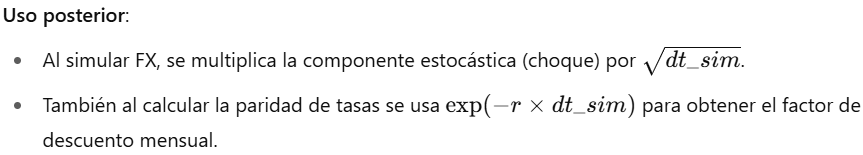

6. dt_calib es el paso de tiempo para calibrar Vasicek, dado que los datos históricos de las tasas están en días hábiles se usa 1/252, si se tuvieran datos semanales o mensuales se tendría que ajustar este parámento. Lo importante es que dt_calib refleje la preiodicidad de las observaciones usadas para calibrar.

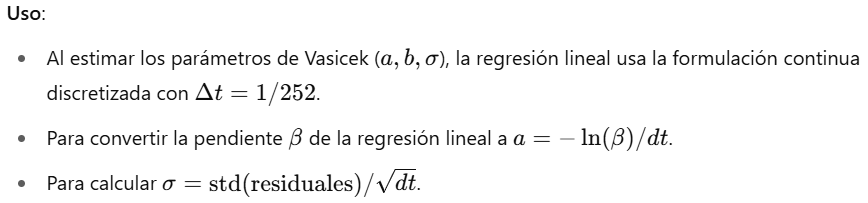

--> Con este bloque de código se calibran las simulaciones del modelo

In [ ]:
# Paso 8: Calibrar Vasicek

parametros_vasicek = {}

for moneda, serie_tasas in tasas_historicas.items():
    print(f"\n--- Calibrando Vasicek para {moneda} ---")

    # 1) Validar que haya al menos dos datos
    if len(serie_tasas) < 2:
        raise ValueError(f"La serie de tasas históricas para {moneda} debe tener al menos 2 datos.")

    # 2) La serie ya está en decimales (0.035 en lugar de 3.5)
    r_array = serie_tasas.values

    # 3) Crear r_t y r_{t+1}
    r_t  = r_array[:-1]
    r_t1 = r_array[1:]

    # 4) Ajustar regresión lineal: r_{t+1} = α + β * r_t + ε
    X = r_t.reshape(-1, 1)
    y = r_t1.reshape(-1, 1)
    modelo = LinearRegression().fit(X, y)

    # 5) Extraer correctamente el único coeficiente e intercepto
    beta  = modelo.coef_[0, 0]
    alpha = modelo.intercept_[0]

    # 6) Definir dt_calib para datos diarios
    dt_calib = 1.0 / 252.0

    # 7) Calcular parámetros a y b del proceso Vasicek
    a = -np.log(beta) / dt_calib
    b = alpha / (1.0 - beta)

    # 8) Calcular sigma usando desvío de residuales anualizado
    residuales = (y - modelo.predict(X)).flatten()
    sigma = np.std(residuales, ddof=0) / np.sqrt(dt_calib)

    parametros_vasicek[moneda] = {'a': a, 'b': b, 'sigma': sigma}
    print(f"a={a:.6f}, b={b:.6f}, sigma={sigma:.6f}")